In [1]:
import os, subprocess
import json
import uproot3
import awkward as ak
import numpy as np
from coffea import processor, util, hist

from plotter import *

In [2]:
lumis = {}
lumis['2016'] = 35.9
lumis['2017'] = 41.5
lumis['2018'] = 59.9

with open('xsec.json') as f:
  xs = json.load(f)

with open('pmap.json') as f:
  pmap = json.load(f)

systematics = ['nominal',
               'jet_triggerUp','jet_triggerDown',
               'btagWeightUp','btagWeightDown','btagEffStatUp','btagEffStatDown',
               'UESUp','UESDown','JESUp','JESDown','JERUp','JERDown',
               'PS_weightUp','PS_weightDown',
              ]

In [3]:
year = '2016'
nfiles = len(subprocess.getoutput("ls infiles-split/"+year+"*.json").split())
outsum = processor.dict_accumulator()

In [4]:
# Load all files
for n in range(1,nfiles+1):

    with open('infiles-split/'+year+'_'+str(n)+'.json') as f:
      infiles = json.load(f)
    
    filename = '/myeosdir/vh-category/outfiles/'+year+'_'+str(n)+'.coffea'
    #filename = 'outfiles/'+year+'_'+str(n)+'.coffea'
    if os.path.isfile(filename):
        out = util.load(filename)
        outsum.add(out)
    else:
        print(n,infiles.keys())
        #print("File " + filename + " is missing")
        
scale_lumi = {k: xs[k] * 1000 *lumis[year] / w for k, w in outsum['sumw'].items()}
outsum['templates'].scale(scale_lumi, 'dataset')
outsum['templates-vh-1'].scale(scale_lumi, 'dataset')
outsum['templates-vh-2'].scale(scale_lumi, 'dataset')
outsum['templates-vh-3'].scale(scale_lumi, 'dataset')

In [5]:
templates = outsum['templates'].group('dataset', hist.Cat('process', 'Process'), pmap)
templates1 = outsum['templates-vh-1'].group('dataset', hist.Cat('process', 'Process'), pmap)
templates2 = outsum['templates-vh-2'].group('dataset', hist.Cat('process', 'Process'), pmap)
templates3 = outsum['templates-vh-3'].group('dataset', hist.Cat('process', 'Process'), pmap)

/opt/conda/lib/python3.8/site-packages/coffea/hist/hist_tools.py:347: RuntimeWarning: Not all requested indices present in <Cat (name=dataset) instance at 0x7f4524f87d30>
  warnings.warn("Not all requested indices present in %r" % self, RuntimeWarning)
/opt/conda/lib/python3.8/site-packages/coffea/hist/hist_tools.py:347: RuntimeWarning: Not all requested indices present in <Cat (name=dataset) instance at 0x7f4524f84a60>
  warnings.warn("Not all requested indices present in %r" % self, RuntimeWarning)
/opt/conda/lib/python3.8/site-packages/coffea/hist/hist_tools.py:347: RuntimeWarning: Not all requested indices present in <Cat (name=dataset) instance at 0x7f4524f98700>
  warnings.warn("Not all requested indices present in %r" % self, RuntimeWarning)
/opt/conda/lib/python3.8/site-packages/coffea/hist/hist_tools.py:347: RuntimeWarning: Not all requested indices present in <Cat (name=dataset) instance at 0x7f4524fa74c0>
  warnings.warn("Not all requested indices present in %r" % self, Runt

In [6]:
# check intergrals
templates.sum('pt1','msd1','ddb1','DR').integrate('region','signal').integrate('systematic', 'nominal').values()

{('ZH',): array(0.10404379),
 ('WH',): array(0.04016806),
 ('VBF',): array(2.44075895),
 ('ggF',): array(10.23996254),
 ('QCD',): array(284580.79689988),
 ('VV',): array(283.04390275),
 ('Wjets',): array(10655.22840508),
 ('Zjets',): array(2914.51245988),
 ('ttbar',): array(1107049.47635045),
 ('singlet',): array(16005.99744017),
 ('data',): array(298143.),
 ('muondata',): array(5950.)}

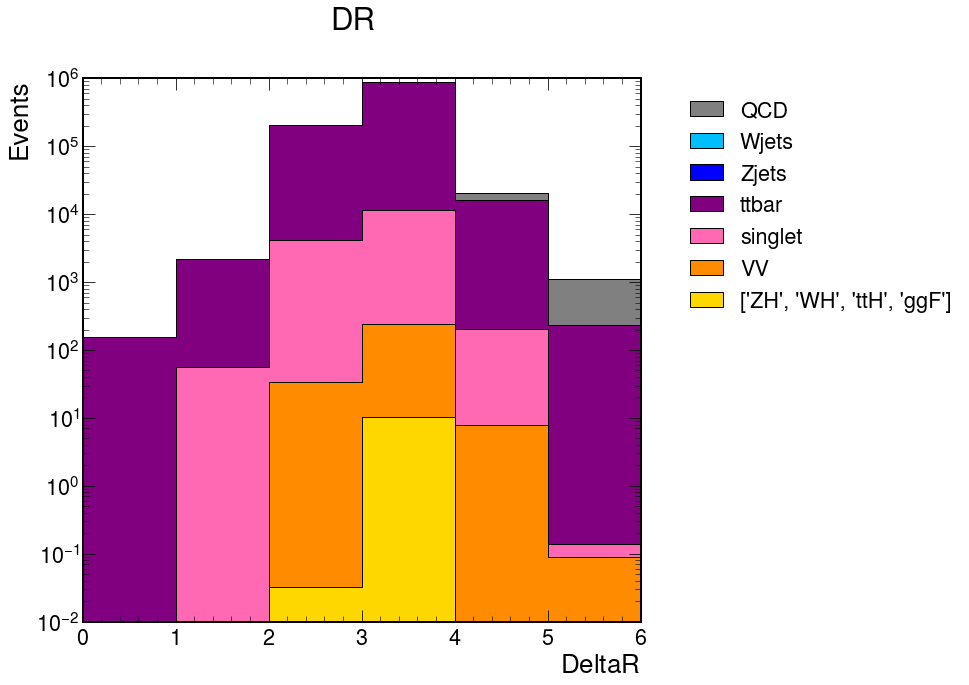

In [7]:
x = templates.sum('pt1','msd1','ddb1').integrate('region','signal').integrate('systematic', 'nominal')
plot_overlay(x,'DR','DR')

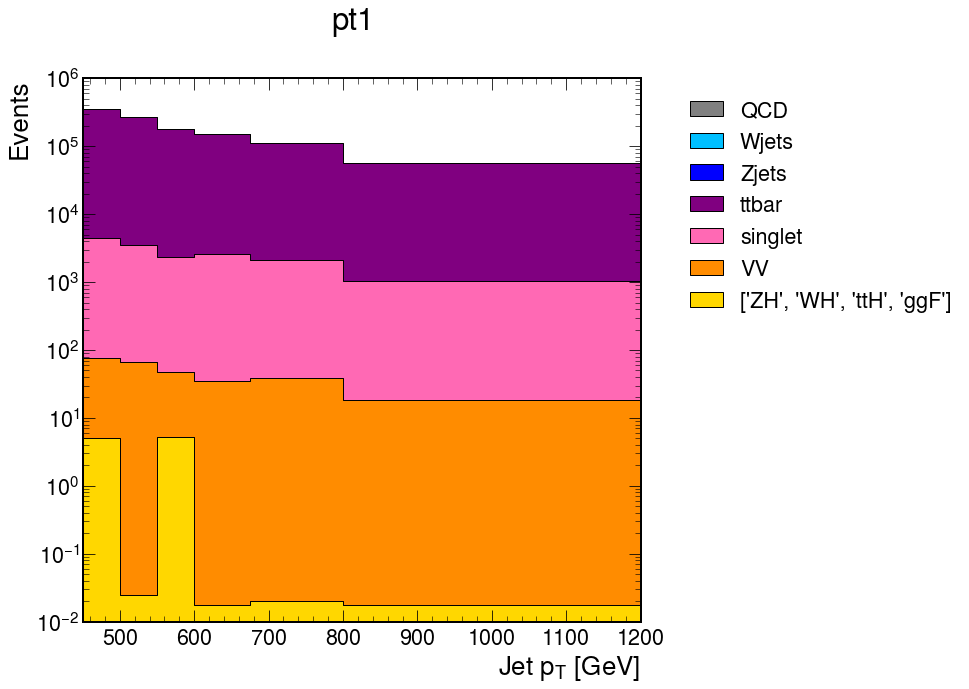

In [8]:
x = templates.sum('msd1','ddb1','DR').integrate('region','signal').integrate('systematic', 'nominal')
plot_overlay(x,'pt1','pt1')

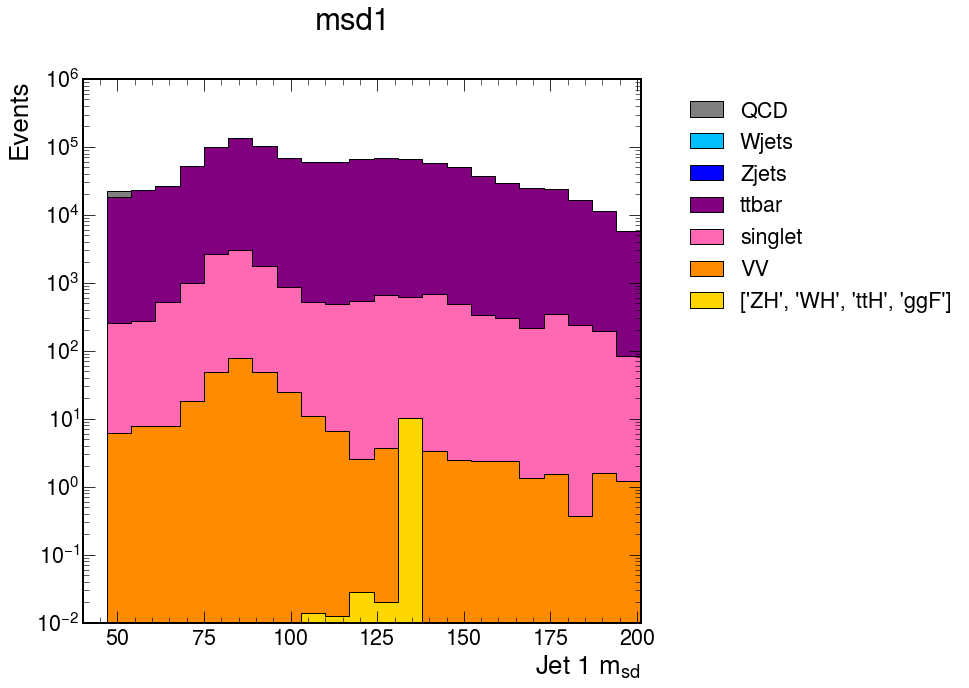

In [9]:
x = templates1.sum('ddb1','ddb2','msd2').integrate('region','signal').integrate('systematic', 'nominal')
plot_overlay(x,'msd1','msd1')

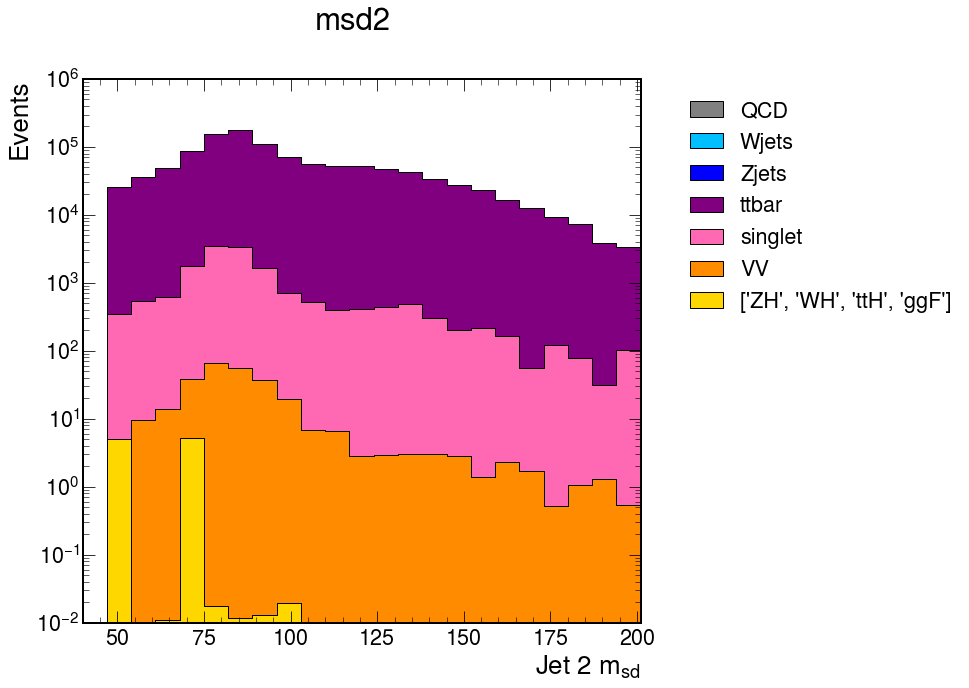

In [10]:
x = templates1.sum('ddb1','ddb2','msd1').integrate('region','signal').integrate('systematic', 'nominal')
plot_overlay(x,'msd2','msd2')

In [11]:
ptbins = [450, 500, 550, 600, 675, 800, 1200]
os.system('rm '+year+'/signalregion.root')
fout = uproot3.create(year+'/signalregion.root')
#for i,b in enumerate(ptbins[:-1]):
#    for p in pmap.keys():  
#        print(p)
#        for s in systematics:
#            h = templates.integrate('region', 'signal').integrate('systematic',s).integrate('pt1',int_range=slice(ptbins[i],ptbins[i+1])).integrate('ddb1',int_range=slice(0.89,1)).integrate('process',p)
#            fout[p+"_pass_pt"+str(i+1)+"_"+s] = hist.export1d(h)
#            h = templates.integrate('region', 'signal').integrate('systematic',s).integrate('pt1',int_range=slice(ptbins[i],ptbins[i+1])).integrate('ddb1',int_range=slice(0,0.89)).integrate('process',p)
#            fout[p+"_fail_pt"+str(i+1)+"_"+s] = hist.export1d(h)

fout.close()

In [12]:
h = templates.sum('pt1','ddb1','DR').integrate('region', 'signal')
mc = ['QCD','Wjets','Zjets','ttbar','singlet','VV']#,'ggF','VBF','ZH','WH']
mc = []

In [20]:
#os.system('rm '+year+'/muonCR.root')
#fout = uproot3.create(year+'/muonCR.root')
#for p in pmap.keys():  
#    print(p)
#    for s in systematics:
#        # muonkin
#        h = templates.integrate('region', 'muoncontrol').integrate('systematic',s).sum('pt1').integrate('ddb1',int_range=slice(0.89,1)).integrate('process',p)
#        fout[p+"_pass_"+s] = hist.export1d(h)
#        h = templates.integrate('region', 'muoncontrol').integrate('systematic',s).sum('pt1').integrate('ddb1',int_range=slice(0,0.89)).integrate('process',p)
#        fout[p+"_fail_"+s] = hist.export1d(h)

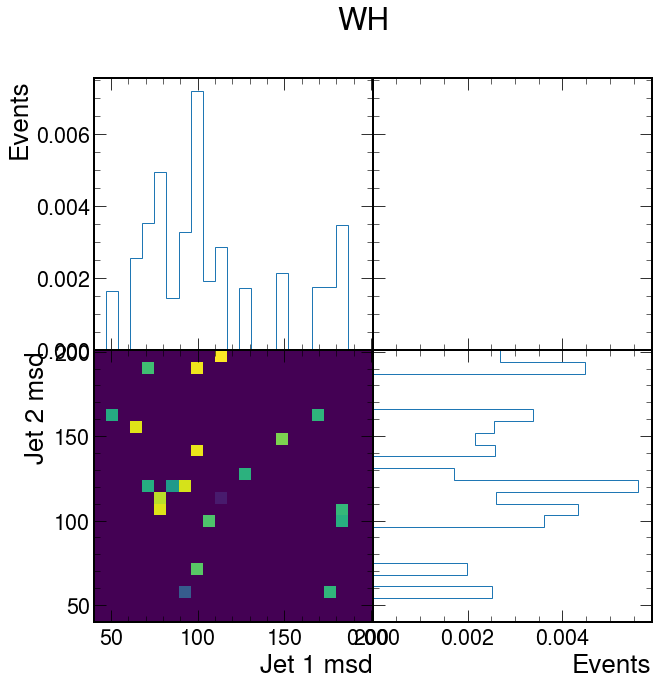

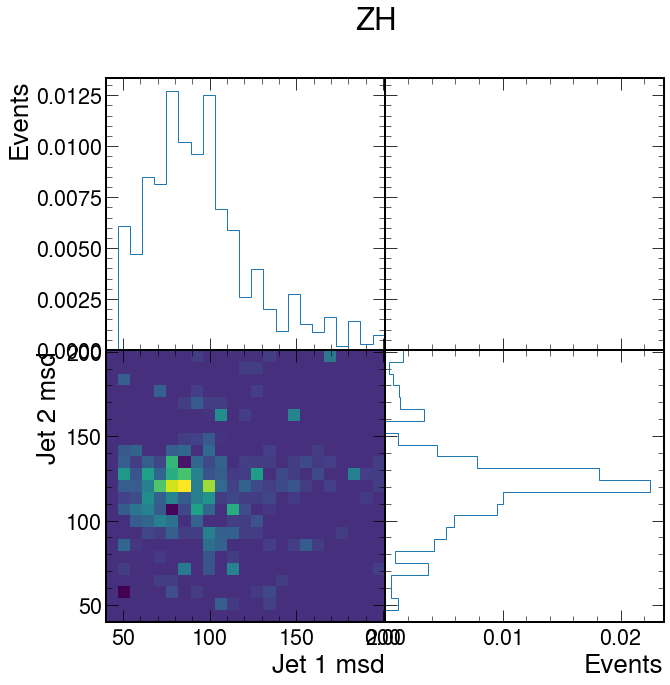

In [21]:
h = templates1.sum('ddb1','ddb2').integrate('region', 'signal').integrate('systematic','nominal')
plot_2d(h.integrate('process','WH'),'msd','WH','WH')
plot_2d(h.integrate('process','ZH'),'msd','ZH','ZH')

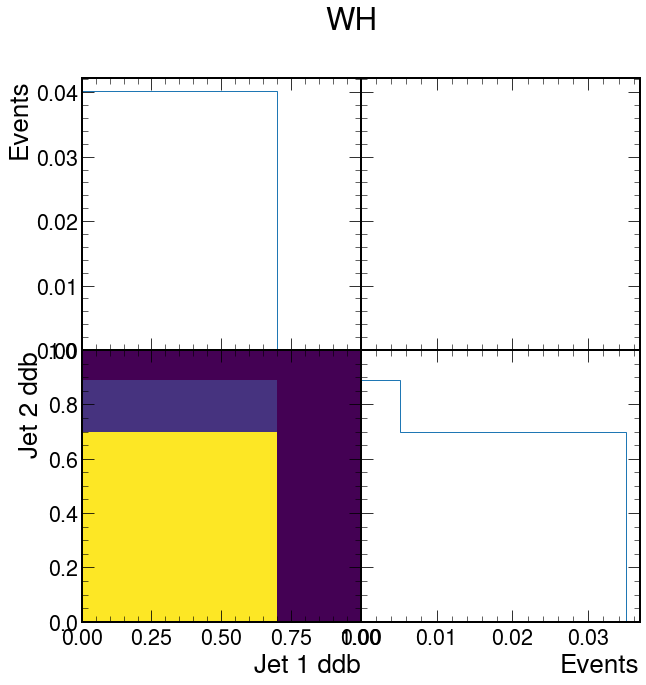

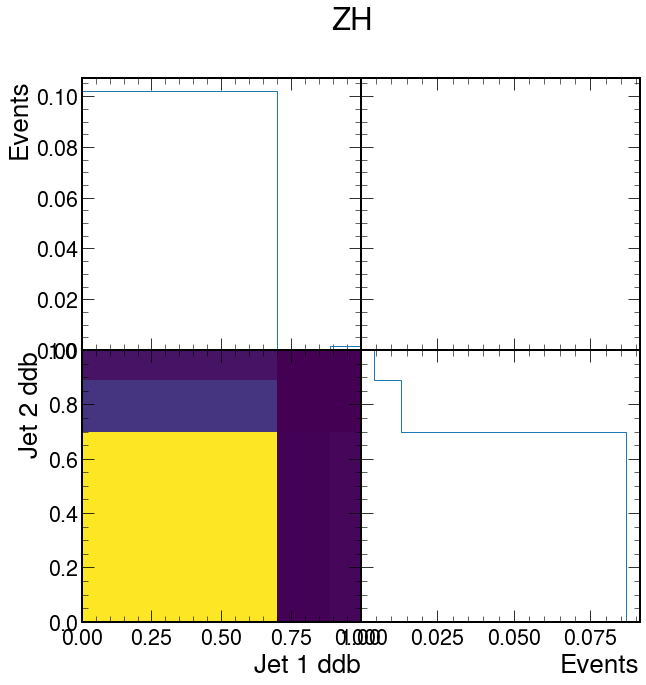

In [22]:
h = templates1.sum('msd1','msd2').integrate('region', 'signal').integrate('systematic','nominal')
plot_2d(h.integrate('process','WH'),'ddb','WH','WH')
plot_2d(h.integrate('process','ZH'),'ddb','ZH','ZH')

In [24]:
#h = templates2.sum('msd1','msd2').integrate('region', 'signal').integrate('systematic','nominal')
#plot_2d(h.integrate('process','WH'),'pt','WH','WH')
#plot_2d(h.integrate('process','ZH'),'pt','ZH','ZH')

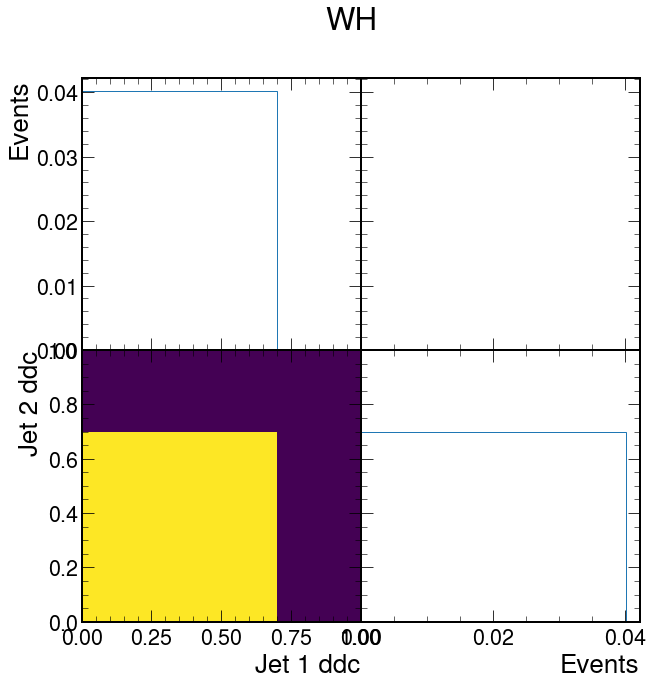

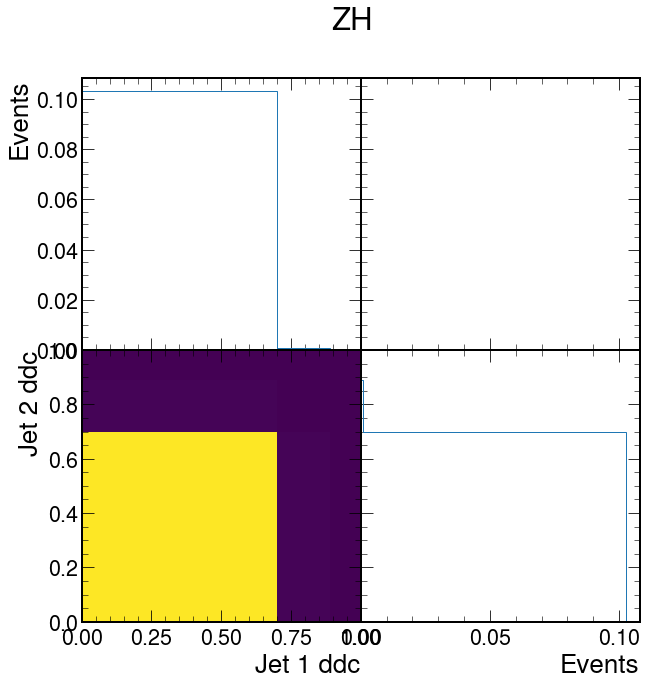

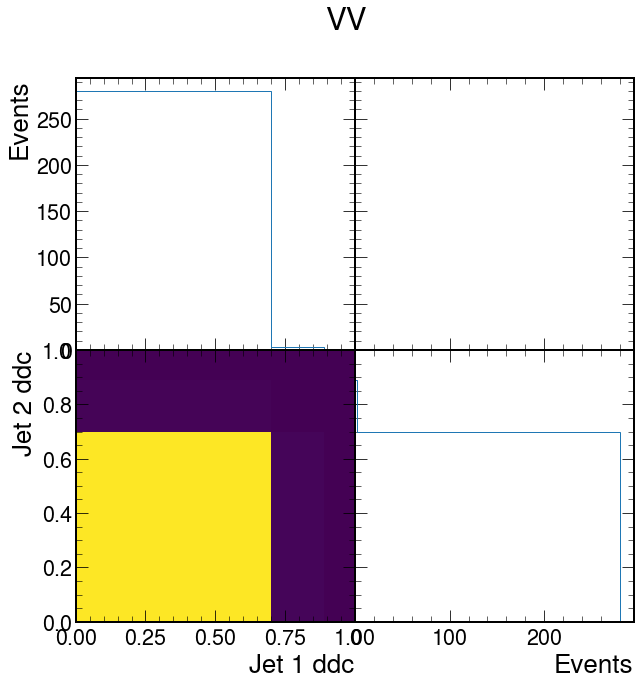

In [26]:
h = templates3.sum('msd1','msd2').integrate('region', 'signal').integrate('systematic','nominal')
plot_2d(h.integrate('process','WH'),'ddc','WH','WH')
plot_2d(h.integrate('process','ZH'),'ddc','ZH','ZH')
plot_2d(h.integrate('process','VV'),'ddc','VV','VV')